In [1]:
# !pip install transformers
# !pip install sentence_transformers

In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from transformers import RobertaModel, RobertaTokenizer
from sentence_transformers import SentenceTransformer
import pickle

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Get the current directory
current_dir = Path.cwd()
encoded_dir = current_dir.parent / "data" / "encoded"
metadata_file_path = current_dir.parent / "data" / "data_and_test_files" / "items_metadata.jsonl"
pre_path = current_dir.parent / "data" / "pre_process"

In [5]:
# Load the item_mapping
with open(pre_path / 'item_mapping.pkl', 'rb') as f:
    item_mapping = pickle.load(f)

In [6]:
df = pd.read_json(metadata_file_path, lines=True)
df.head(1)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,AMAZON FASHION,BALEAF Women's Long Sleeve Zip Beach Coverup U...,4.2,422,"[90% Polyester, 10% Spandex, Zipper closure, M...",[],31.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Women's UPF 50+ Front Zip Beach Co...,BALEAF,"[Clothing, Shoes & Jewelry, Women, Clothing, S...","{'Department': 'womens', 'Date First Available...",B09X1MRDN6,NaN,NaN,NaN


In [7]:
df.dtypes

main_category       object
title               object
average_rating     float64
rating_number        int64
features            object
description         object
price               object
images              object
videos              object
store               object
categories          object
details             object
parent_asin         object
bought_together    float64
subtitle            object
author              object
dtype: object

# Fix the data (convert dtypes to str and price to numeric)

### Convert the columns to the correct dtypes:

In [8]:
import numpy as np

# Clean the 'price' column: Replace non-numeric values with NaN
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Correct the dtypes for the rest of the columns
df = df.astype({
    'main_category': 'string',
    'title': 'string',
    'average_rating': 'float64',
    'rating_number': 'int64',
    'features': 'object',  # Leave as object since it's a list
    'description': 'object',  # Leave as object since it's a list
    'images': 'object',  # Leave as object since it's a list
    'videos': 'object',  # Leave as object since it's a list
    'store': 'string',
    'categories': 'object',  # Leave as object since it's a list
    'details': 'object',  # Leave as object since it's a dictionary
    'parent_asin': 'string',
    'bought_together': 'float64',
    'subtitle': 'string',
    'author': 'string'
})

# Verify the updated dtypes
print(df.dtypes)

main_category      string[python]
title              string[python]
average_rating            float64
rating_number               int64
features                   object
description                object
price                     float64
images                     object
videos                     object
store              string[python]
categories                 object
details                    object
parent_asin        string[python]
bought_together           float64
subtitle           string[python]
author             string[python]
dtype: object


### turn features, description, categories and details into str.

In [9]:
# Convert lists to string by joining their elements with a delimiter (e.g., space)
df['features'] = df['features'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
df['description'] = df['description'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
df['categories'] = df['categories'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Convert dictionary in 'details' to string (you can modify this to extract specific keys if needed)
df['details'] = df['details'].apply(lambda x: ' '.join(f"{k}: {v}" for k, v in x.items()) if isinstance(x, dict) else str(x))

# # Now concatenate these columns into a single long string
# df['long_string_with_markers'] = df['features'] + ' ' + df['description'] + ' ' + df['categories'] + ' ' + df['details']


In [10]:
df.dtypes

main_category      string[python]
title              string[python]
average_rating            float64
rating_number               int64
features                   object
description                object
price                     float64
images                     object
videos                     object
store              string[python]
categories                 object
details                    object
parent_asin        string[python]
bought_together           float64
subtitle           string[python]
author             string[python]
dtype: object

In [11]:
df = df.astype({
    'main_category': 'string',
    'title': 'string',
    'average_rating': 'float64',
    'rating_number': 'int64',
    'features': 'string',  # changed to string
    'description': 'string', # changed to string
    'images': 'object',  # Leave as object since it's a list
    'videos': 'object',  # Leave as object since it's a list
    'store': 'string',
    'categories': 'string',  # changed to string
    'details': 'string',  # changed to string
    'parent_asin': 'string',
    'bought_together': 'float64',
    'subtitle': 'string',
    'author': 'string'
})

In [12]:
df

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,AMAZON FASHION,BALEAF Women's Long Sleeve Zip Beach Coverup U...,4.2,422,"90% Polyester, 10% Spandex Zipper closure Mach...",,31.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Women's UPF 50+ Front Zip Beach Co...,BALEAF,"Clothing, Shoes & Jewelry Women Clothing Swims...",Department: womens Date First Available: April...,B09X1MRDN6,NaN,<NA>,<NA>
1,AMAZON FASHION,"SAS Women's, Relaxed Sandal",4.7,618,Made in the USA Suede sole Heel measures appro...,"Unwind, leave your worries behind, and simply ...",188.95,[{'thumb': 'https://m.media-amazon.com/images/...,[],SAS,"Clothing, Shoes & Jewelry Women Shoes Sandals ...",Product Dimensions: 10 x 15 x 6 inches; 2 Poun...,B0944VG4Y4,NaN,<NA>,<NA>
2,AMAZON FASHION,SheIn Women's Basic Stretch Plaid Mini Bodycon...,3.8,999,Zipper closure Fabric has some stretch; Please...,,12.99,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'SUPER CUTE plaid skirt!', 'url': '...",SheIn,"Clothing, Shoes & Jewelry Novelty & More Cloth...",Department: womens Date First Available: Septe...,B08JGGF5TJ,NaN,<NA>,<NA>
3,AMAZON FASHION,Amazon Essentials Women's Surplice Dress (Avai...,4.4,7096,"95% Viscose, 5% Elastane Imported No Closure c...",Amazon Essentials is focused on creating affor...,19.92,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Easy throw on dress! Comfortable, ...",Amazon Essentials,"Clothing, Shoes & Jewelry Women Clothing Dress...",Item model number: AE1932668 Department: women...,B096HDRB6R,NaN,<NA>,<NA>
4,AMAZON FASHION,"Fotociti Yoga Shorts for Women – 5"" High Waist...",4.5,2911,"92% Polyester, 8% Spandex Imported Pull On clo...",,15.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Cute Blue Camo Yoga Bike Shorts Re...,Fotociti,"Clothing, Shoes & Jewelry Women Clothing Activ...",Package Dimensions: 10 x 8 x 0.6 inches; 7.04 ...,B089YJ8P6X,NaN,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220885,AMAZON FASHION,weryerker 7 Chakra GemStones Empty Necklace Co...,4.7,302,【Chakra Healing Crystals Set】 - the package in...,,9.92,[{'thumb': 'https://m.media-amazon.com/images/...,[],weryerker,"Clothing, Shoes & Jewelry Women Jewelry Necklaces",Department: womens Date First Available: July ...,B0B5L18YMS,NaN,<NA>,<NA>
220886,AMAZON FASHION,Bukesiyi Sasquatch Hat Bigfoot Embroidered Tru...,4.8,54,"65% Polyester, 35% Cotton 进口 Snap closure Hand...",,16.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],Bukesiyi,"Clothing, Shoes & Jewelry Men Accessories Hats...",Product Dimensions: 10.2 x 7.8 x 4.6 inches; 2...,B0B8VTSJTJ,NaN,<NA>,<NA>
220887,<NA>,4 Pairs Bohemian Vintage Dangle Earrings Retro...,4.5,5874,Package Includes: you will receive 4 pairs of ...,,9.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],meekoo,"Clothing, Shoes & Jewelry Women Jewelry Earrin...","Date First Available: May 10, 2023 Manufacture...",B0C4TC78JH,NaN,<NA>,<NA>
220888,AMAZON FASHION,Steve Madden Men's Troopah-c Combat Boot,3.7,225,100% Leather Imported Synthetic sole Shaft mea...,"Rugged, well-worn leather adds vintage appeal ...",114.07,[{'thumb': 'https://m.media-amazon.com/images/...,[],Steve Madden,"Clothing, Shoes & Jewelry Men Shoes Boots Moto...",Item Weight: 1.19 Pounds Item model number: TR...,B075Y7SBK1,NaN,<NA>,<NA>


### Create one long tensor containing for each row (each item), its string meta data

In [13]:
def create_long_string_with_markers(df, excluded_columns=None, output_column_name="long_string_with_markers"):
    """
    Creates a long string from all string columns with clear markers indicating column names.
    The resulting string is added to the DataFrame as a new column.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        excluded_columns (list): Columns to exclude from the long string (default: None).
        output_column_name (str): Name of the new column to store the long string (default: "long_string_with_markers").
    
    Returns:
        pd.DataFrame: DataFrame with the new column added.
    """
    # Default excluded columns
    if excluded_columns is None:
        excluded_columns = []

    # Select all string columns except excluded ones
    string_columns = df.select_dtypes(include='string').drop(columns=excluded_columns)

    # Create the long string with column markers for each row
    df[output_column_name] = string_columns.apply(
        lambda row: ' '.join([f"<{col}> {str(val).strip()} </{col}>" for col, val in row.dropna().items()]),
        axis=1
    )

    return df

# Example usage
df = create_long_string_with_markers(df, excluded_columns=['parent_asin'], output_column_name="long_string_with_markers")




### Display a sample of the new column:

In [14]:
print("Sample of the new column:")
print(df["long_string_with_markers"].iloc[0])  # Display the first row of the new column

Sample of the new column:
<main_category> AMAZON FASHION </main_category> <title> BALEAF Women's Long Sleeve Zip Beach Coverup UPF 50+ Sun Protection Hooded Cover Up Shirt Dress with Pockets </title> <features> 90% Polyester, 10% Spandex Zipper closure Machine Wash Long sleeve sun protection coverups--UPF 50+ blocks the sun from burning Zipped v-neckline--fashionable V neck and smooth 1/4 zipper allows to staying place as you like Two drop-in side pockets--hold your phone or keys well，no worries of falling out Hoodie with non-slip drawcord--Enhancing hooded design is convenient to wrap your face and enough space to put your head and hair easily A flattering coverups company you spend all day on the beach，traveling with lovers or busying around house. Recommended For everyday leisure or daily exercise </features> <description>  </description> <store> BALEAF </store> <categories> Clothing, Shoes & Jewelry Women Clothing Swimsuits & Cover Ups Cover-Ups </categories> <details> Department: 

In [15]:
df.head(1)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author,long_string_with_markers
0,AMAZON FASHION,BALEAF Women's Long Sleeve Zip Beach Coverup U...,4.2,422,"90% Polyester, 10% Spandex Zipper closure Mach...",,31.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Women's UPF 50+ Front Zip Beach Co...,BALEAF,"Clothing, Shoes & Jewelry Women Clothing Swims...",Department: womens Date First Available: April...,B09X1MRDN6,NaN,<NA>,<NA>,<main_category> AMAZON FASHION </main_category...


#### Choose the most suitable model for creating embeddings. We want to use bert, but which one should we use?
#### The tradeoff is obvious, a big model would be harder and more time consuming. We also want best performance. Let's check the length of the string to better understand which model to use

In [16]:
df['string_length'] = df['long_string_with_markers'].apply(len)

# Calculate average and median length
min_length = df['string_length'].min()
avg_length = df['string_length'].mean()
median_length = df['string_length'].median()
max_length = df['string_length'].max()

In [17]:
min_length,avg_length,median_length,max_length

(224, 1427.4324279052921, 1291.0, 19817)

<Axes: >

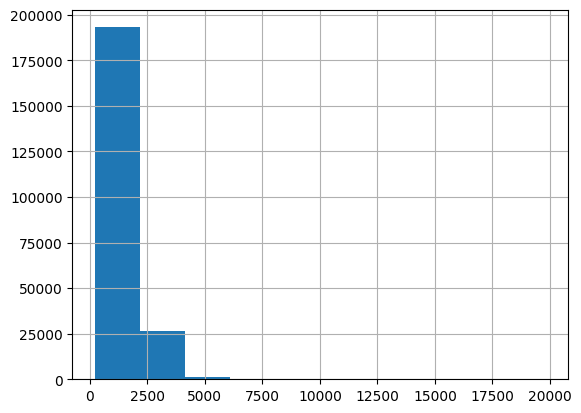

In [18]:
df['string_length'].hist()

### We decided to use longformer as most of the inputs are longer than 512, so the ordinary bert isnt great.
### with Longformer and its special attention mechanism we can have a much larger input and stay with a psudo-linear speed.

In [19]:
!pip install SentencePiece 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.5 MB/s eta 0:00:00a 0:00:01


In [20]:
df.columns

Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'parent_asin', 'bought_together', 'subtitle', 'author',
       'long_string_with_markers', 'string_length'],
      dtype='object')

In [24]:
import torch
from transformers import LongformerTokenizer, LongformerModel
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from huggingface_hub import login

# Login with your Hugging Face token
login(token='') ### Put your token here

skip_lst =[]
# Step 1: Load the Longformer model and tokenizer
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-large-4096")
model = LongformerModel.from_pretrained("allenai/longformer-large-4096")

# Ensure the model is in evaluation mode
model.eval()

# Step 2: Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
numeric_features=["price","average_rating","rating_number"]

for feature in numeric_features:
# Step 3: Initialize the scaler for normalizing the price
    scaler = MinMaxScaler()
    number_to_impute = -1
    # Step 4: Normalize the price column (assuming df has a 'price' column)
    df[f'normalized_{feature}'] = scaler.fit_transform(df[[feature]])
    na_count = df[f'normalized_{feature}'].isna().sum()
    print(f"there are {na_count} nas in the feature: {feature}. filling with {number_to_impute}")
    df[f'normalized_{feature}'] = df[f'normalized_{feature}'].fillna(number_to_impute)

# Step 5: Create a dictionary with df.parent_asin as key and embeddings + price as value
embedding_dict = {}

# Step 6: Iterate through each row in the dataframe and generate embeddings
for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing rows"):
    parent_asin = row['parent_asin']
    long_string = row['long_string_with_markers']
    price = row['normalized_price']  # The normalized price
    average_rating = row['normalized_average_rating'] 
    rating_number = row['normalized_rating_number'] 
    # Tokenize the long string and get embeddings
    inputs = tokenizer(long_string, return_tensors="pt", truncation=True, padding=True, max_length=4096)

    # Move the inputs to GPU
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get the output from the model (this includes the embeddings)
    with torch.no_grad():  # No need to compute gradients
        outputs = model(**inputs)

    # We typically use the last hidden state for the embeddings
    text_embedding = outputs.last_hidden_state.mean(dim=1)  # Mean pooling across tokens

    # Step 7: Concatenate the price with the text embeddings
    # We make sure that the price is a tensor of the same shape (1 x 1)
    price_tensor = torch.tensor([[price]], dtype=torch.float).to(device)
    average_rating_tensor = torch.tensor([[average_rating]], dtype=torch.float).to(device)
    rating_number_tensor = torch.tensor([[rating_number]], dtype=torch.float).to(device)
    # Concatenate the embeddings and price (text_embedding is [1, embedding_size], price_tensor is [1, 1])
    combined_embedding = torch.cat((text_embedding, price_tensor, average_rating_tensor, rating_number_tensor), dim=1).squeeze().reshape(-1)
    if parent_asin in item_mapping.keys():
        # Step 8: Store the combined embedding in the dictionary with parent_asin as the key
        embedding_dict[item_mapping[parent_asin]] = combined_embedding
    else:
        skip_lst.append(parent_asin)
print(f"qty skipped:{len(skip_lst)}. List of skipped:{skip_lst}")
# Step 9: Save the dictionary as a .pt file
torch.save(embedding_dict, '/storage/yahlly/RecSys/data/encoded/embedding_dict_with_price_longformer_idx.pt')

print("Dictionary of embeddings with price saved as 'embedding_dict_with_price_longformer.pt'")


there are 60317 nas in the feature: price. filling with -1
there are 0 nas in the feature: average_rating. filling with -1
there are 0 nas in the feature: rating_number. filling with -1


Processing rows: 100%|██████████| 220890/220890 [7:50:39<00:00,  7.82it/s]  


qty skipped:22119. List of skipped:['B0944VG4Y4', 'B09WTRYB31', 'B07TVHSDMQ', 'B08HSFNQHX', 'B08HH18DSZ', 'B07MZW5Y4C', 'B0916FY697', 'B00J0IEP3G', 'B07CLMF8Y9', 'B07JCMNZWK', 'B099N2FHT6', 'B00UKCY3MY', 'B073Q3KC29', 'B06XR88HKT', 'B093QSSNW3', 'B07FKVJ14D', 'B0BSF48BRK', 'B09CKHSSPF', 'B08B4J86CH', 'B0067IC7XC', 'B082LX5J1S', 'B079P88LF9', 'B0BLVL7MP6', 'B07X8DFBGB', 'B07TN4NB9D', 'B0B76HJVFR', 'B0BRC2JR17', 'B07DMJQXCG', 'B0796QVRYW', 'B07BXQ335F', 'B09MKQQT3K', 'B07M7C7VRY', 'B07G6YHJSQ', 'B009IWAUTM', 'B07J15KMMN', 'B07BHSL22M', 'B07C986NJ8', 'B07VKLXSMF', 'B09QT6CV54', 'B00RK351TA', 'B00XZATUN0', 'B07BLXBNVN', 'B09VC4GPPN', 'B07NVHQ44R', 'B08KRN32K3', 'B07Z4619N8', 'B0B5R4ZQNM', 'B07LCGTBN4', 'B08BJ2NZVG', 'B01M8GTB7F', 'B07P8Q7CTC', 'B08FC85TXD', 'B07KN5B4SK', 'B008CJ62Y4', 'B0B9K16YR3', 'B0884M1FRC', 'B07BQNGXLN', 'B0BRP99NJM', 'B0BN19D48L', 'B002JVWOO8', 'B07FQNGGHP', 'B08ZQTYLZW', 'B07QJXB7D9', 'B074XM3H5L', 'B07K598JQ1', 'B07QY9WXQQ', 'B0756MJ3V6', 'B00EYBI67U', 'B01M1OI9FW'

### Load embedded dict

In [26]:
embedding_dict = torch.load('/storage/yahlly/RecSys/data/encoded/embedding_dict_with_price_longformer_idx.pt')

# Print the keys and the shape of one of the embeddings to check
print(f"Number of entries in the embedding dictionary: {len(embedding_dict)}")
sample_key = list(embedding_dict.keys())[4]  # Get a sample key
print(f"Sample key (parent_asin): {sample_key}")
print(f"Shape of the embedding for this key: {embedding_dict[sample_key].shape}")

Number of entries in the embedding dictionary: 198771
Sample key (parent_asin): 44993
Shape of the embedding for this key: torch.Size([1027])


In [27]:
embedding_dict

{131488: tensor([-0.0118, -0.0987, -0.2878,  ...,  0.0095,  0.8000,  0.0010],
        device='cuda:0'),
 49667: tensor([-0.0573, -0.1541, -0.4666,  ...,  0.0039,  0.7000,  0.0024],
        device='cuda:0'),
 13509: tensor([-0.0399, -0.1226, -0.3553,  ...,  0.0059,  0.8500,  0.0174],
        device='cuda:0'),
 98102: tensor([-0.0154, -0.0735, -0.3964,  ...,  0.0047,  0.8750,  0.0071],
        device='cuda:0'),
 44993: tensor([ 0.0026, -0.0701, -0.3936,  ...,  0.0297,  0.8750,  0.0089],
        device='cuda:0'),
 1965: tensor([ 6.8136e-03, -4.6083e-02, -3.4628e-01,  ..., -1.0000e+00,
          9.0000e-01,  7.7381e-04], device='cuda:0'),
 92911: tensor([-0.0280, -0.1065, -0.4042,  ...,  0.0059,  0.8500,  0.0031],
        device='cuda:0'),
 143124: tensor([ 4.3198e-02, -8.0334e-02, -3.8567e-01,  ..., -1.0000e+00,
          9.2500e-01,  3.2079e-04], device='cuda:0'),
 111847: tensor([ 0.0402, -0.0127, -0.5208,  ...,  0.0077,  0.8750,  0.0054],
        device='cuda:0'),
 4596: tensor([ 0.002